# U-Net
In this notebook, we build a *very* basic U-Net.

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('..')
from diffusion_models import utils

DATA_PATH = '../data/'
train_loader, test_loader = utils.get_mnist(32, DATA_PATH)

## Down blocks and up blocks
The U-Net architecture is composed of a contracting path (left side) and an expansive path (right side). The contracting path follows the typical architecture of a convolutional network, with a series of convolutional and pooling layers. The expansive path combines the feature maps from the contracting path with the corresponding feature maps in the expansive path. This is done by concatenating the feature maps from the contracting path with the feature maps in the expansive path. The expansive path is composed of a series of up-sampling and convolutional layers.

Since we have some skip connections, we have to return the feature maps from the contracting path before pooling.

In [3]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

    
    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.pool1(x1)
        return x1, x2
    

class UpBlock(nn.Module):
    def __init__(self, in_channels, residual_channels, out_channels):
        super().__init__()

        self.upconv1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels=in_channels + residual_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)


    def forward(self, x1, residual):
        x3 = self.upconv1(x1)
        x3 = torch.cat([x3, residual], dim=1)
        x4 = F.relu(self.bn1(self.conv1(x3)))
        return x4
            

class UNetSmol(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super().__init__()

        # Encoder
        self.down1 = DownBlock(in_channels=input_channels, out_channels=4)
        self.down2 = DownBlock(in_channels=4, out_channels=8)

        # Bottleneck
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=16)

        # Decoder
        self.up1 = UpBlock(in_channels=16, residual_channels=8, out_channels=8)
        self.up2 = UpBlock(in_channels=8, residual_channels=4, out_channels=4)
        self.conv6 = nn.Conv2d(4, output_channels, kernel_size=1)


    def forward(self, x, labels=None):
        x1, x2 = self.down1(x)
        x3, x4 = self.down2(x2)

        x5 = F.relu(self.bn3(self.conv3(x4)))

        x6 = self.up1(x5, x3)
        x7 = self.up2(x6, x1)

        x8 = self.conv6(x7)
        return x8

## Train the model
We use MSE loss again. We do not impose any constraints on the latent space.

In [4]:
model = UNetSmol()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for img, clean_imgs, _ in tqdm(train_loader):
        # add some noise to the image
        noise_factor = np.random.rand() * 0.5
        noisy_imgs = utils.add_noise(img, noise_factor)
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img, clean_imgs, _ in test_loader:
            noise_factor = np.random.rand() * 0.5
            noisy_imgs = utils.add_noise(img, noise_factor)
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            val_loss += loss.item()
    
    print(f'Validation Loss: {val_loss/len(test_loader):.4f}')


100%|██████████| 1875/1875 [00:58<00:00, 31.96it/s]


Epoch [1/5], Loss: 0.1126
Validation Loss: 0.0245


100%|██████████| 1875/1875 [00:58<00:00, 32.22it/s]


Epoch [2/5], Loss: 0.0184
Validation Loss: 0.0218


100%|██████████| 1875/1875 [01:06<00:00, 28.20it/s]


Epoch [3/5], Loss: 0.0172
Validation Loss: 0.0215


100%|██████████| 1875/1875 [01:10<00:00, 26.45it/s]


Epoch [4/5], Loss: 0.0161
Validation Loss: 0.0194


100%|██████████| 1875/1875 [01:02<00:00, 29.78it/s]


Epoch [5/5], Loss: 0.0163
Validation Loss: 0.0215


The loss so far looks OK. And if you flip back to the original Autoencoder, the loss is quite a bit lower for the U-Net.

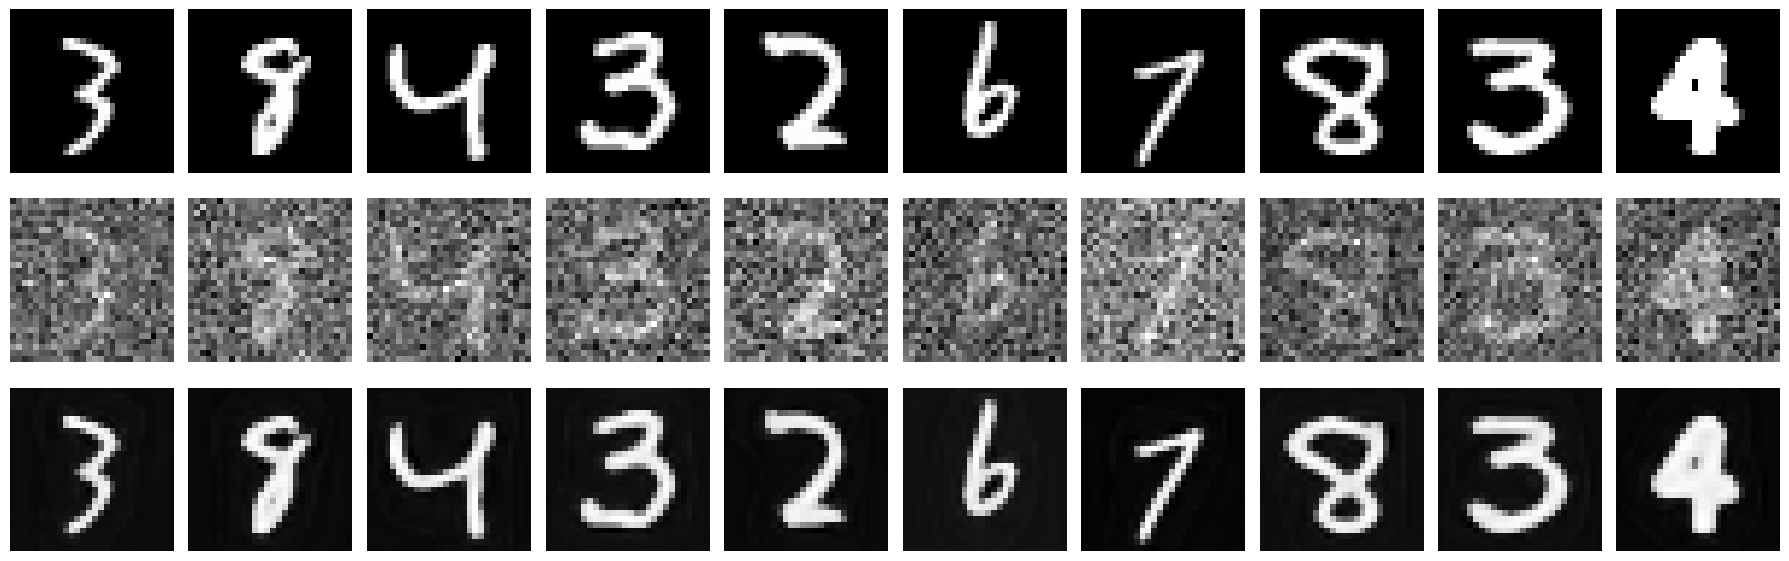

In [25]:
image, target, label = next(iter(test_loader))
noisy_imgs = utils.add_noise(image, 0.5)
out = model(image).detach().numpy()

# plot 10 images and the results
fig, ax = plt.subplots(3, 10, figsize=(18, 6))
for i in range(10):
    ax[0, i].imshow(image[i].squeeze(), cmap='gray')
    ax[1, i].imshow(noisy_imgs[i].squeeze(), cmap='gray')
    ax[2, i].imshow(out[i].squeeze(), cmap='gray')
    # no axis
    for a in ax.ravel():
        a.axis('off')

plt.tight_layout()
plt.show()

What happens if I just stuff pure noise into this model...?

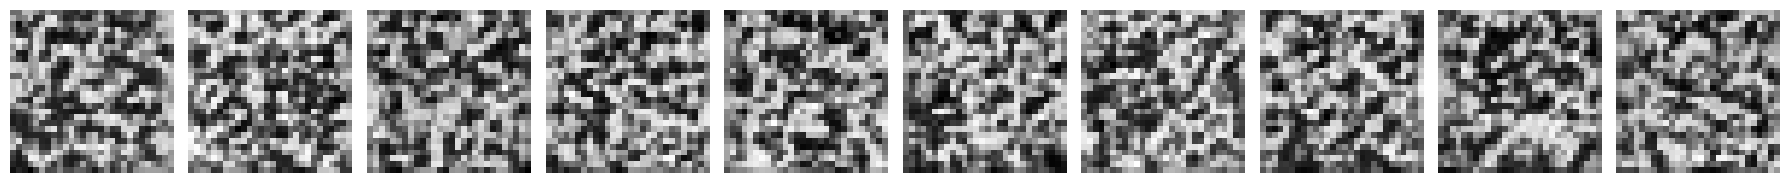

In [28]:
pure_noise = torch.randn(10, 1, 28, 28)
out = model(pure_noise).detach().numpy()

fig, ax = plt.subplots(1, 10, figsize=(18, 3))
for i in range(10):
    ax[i].imshow(out[i].squeeze(), cmap='gray')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

OK, well that's total nonsense. Let's try something else...

# Add labels as features
We make a very simple label encoder that takes the labels and adds them as features to the input. We then train the U-Net on this data.

In [29]:
class LabelEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(10, 16),
            nn.ReLU(),
            nn.Linear(16, 32)
        )

    def forward(self, x):
        return self.encoder(x)

Annoyingly, we need to modify our U-Net to accept the additional features.

In [44]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=2)


    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.pool1(x1)
        return x1, x2
    

class UpBlock(nn.Module):
    def __init__(self, in_channels, residual_channels, out_channels):
        super().__init__()

        self.upconv1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels=in_channels + residual_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)


    def forward(self, x1, residual):
        x3 = self.upconv1(x1)
        x3 = torch.cat([x3, residual], dim=1)
        x4 = F.relu(self.bn1(self.conv1(x3)))
        return x4
            

class UNetSmol(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super().__init__()

        # Encoder
        self.down1 = DownBlock(in_channels=input_channels, out_channels=4)
        self.down2 = DownBlock(in_channels=4, out_channels=8)

        # Bottleneck
        self.conv3 = nn.Conv2d(8, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        # Decoder
        # We have to make sure that the input channels match up
        # 32 from the bottleneck + 32 from the labels
        self.up1 = UpBlock(in_channels=64, residual_channels=8, out_channels=8)
        # 8 from the previous layer + 32 from the labels
        self.up2 = UpBlock(in_channels=40, residual_channels=4, out_channels=4)
        self.conv6 = nn.Conv2d(4, output_channels, kernel_size=1)

        self.label_encoder = LabelEncoder()


    def forward(self, x, labels=None):
        x1, x2 = self.down1(x)
        x3, x4 = self.down2(x2)

        x5 = F.relu(self.bn3(self.conv3(x4)))

        labels = self.label_encoder(labels)
        # tile labels to shape  (batch_size, 32, 7, 7)
        labels_1 = labels.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 14, 14)
        x3 = torch.cat([x3, labels_1], dim=1)

        x6 = self.up1(x5, x3)

        labels_2 = labels.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 28, 28)
        x1 = torch.cat([x1, labels_2], dim=1)

        x7 = self.up2(x6, x1)

        x8 = self.conv6(x7)
        return x8

In [45]:
model = UNetSmol()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The only thing that changes is that we now feed in the labels as input

In [50]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for image, target, labels in tqdm(train_loader):
        noise_factor = np.random.rand()
        noisy_imgs = utils.add_noise(image, noise_factor)
        noisy_imgs, target = noisy_imgs.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(noisy_imgs, labels)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for image, target, labels in test_loader:
            noise_factor = np.random.rand()
            noisy_imgs = utils.add_noise(image, noise_factor)
            noisy_imgs, target = noisy_imgs.to(device), target.to(device)
            outputs = model(noisy_imgs, labels)
            loss = criterion(outputs, target)
            val_loss += loss.item()
    
    print(f'Validation Loss: {val_loss/len(test_loader):.4f}')


100%|██████████| 1875/1875 [03:40<00:00,  8.52it/s]


Epoch [1/5], Loss: 0.0988
Validation Loss: 0.1523


100%|██████████| 1875/1875 [03:46<00:00,  8.28it/s]


Epoch [2/5], Loss: 0.0972
Validation Loss: 0.1576


100%|██████████| 1875/1875 [03:43<00:00,  8.41it/s]


Epoch [3/5], Loss: 0.0976
Validation Loss: 0.1722


 84%|████████▍ | 1574/1875 [03:00<00:34,  8.73it/s]


KeyboardInterrupt: 

We do the same as before to assess the denoising capabilities.

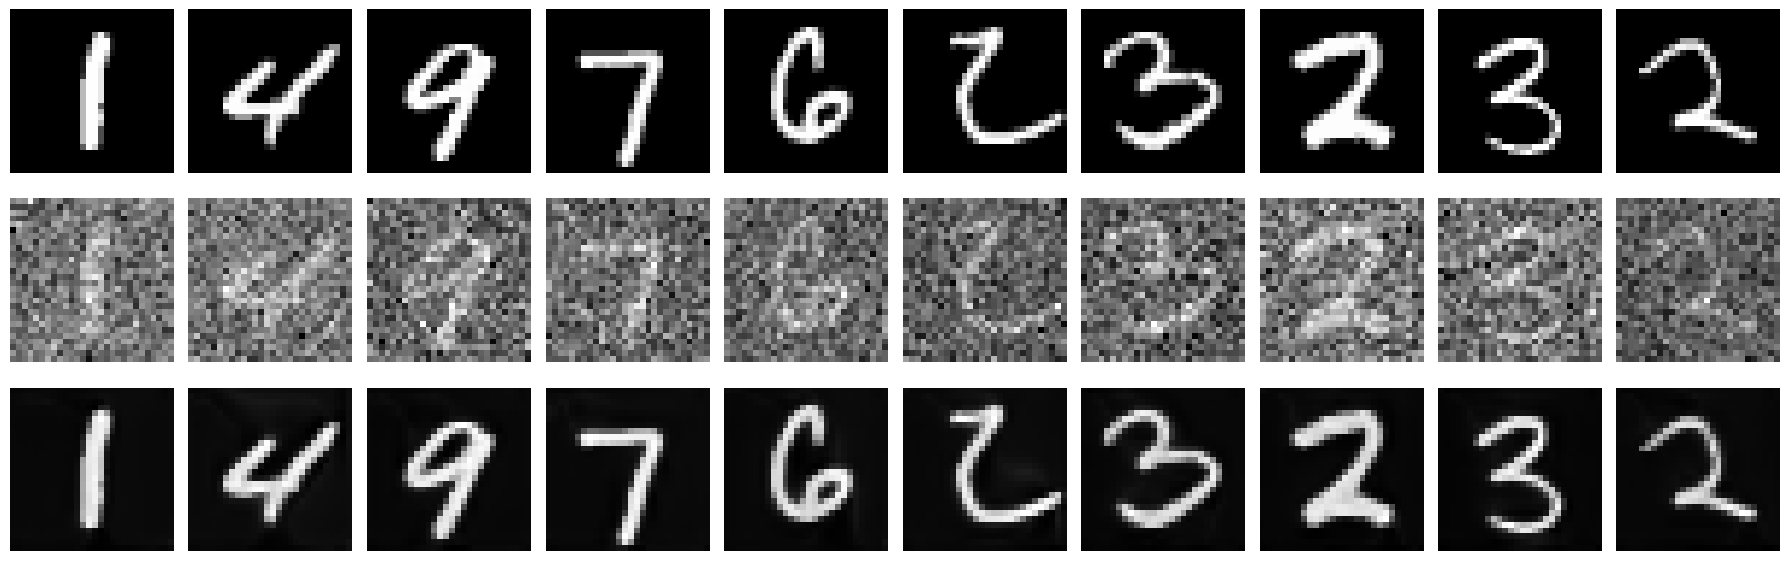

In [51]:
image, target, label = next(iter(test_loader))
noisy_imgs = utils.add_noise(image, 0.5)
out = model(image, label).detach().numpy()

# plot 10 images and the results
fig, ax = plt.subplots(3, 10, figsize=(18, 6))
for i in range(10):
    ax[0, i].imshow(image[i].squeeze(), cmap='gray')
    ax[1, i].imshow(noisy_imgs[i].squeeze(), cmap='gray')
    ax[2, i].imshow(out[i].squeeze(), cmap='gray')
    # no axis
    for a in ax.ravel():
        a.axis('off')

plt.tight_layout()
plt.show()

OK great, that worked fine as before. Now let's try and add some noise into the model _*and*_ some labels to predict and see how it does...

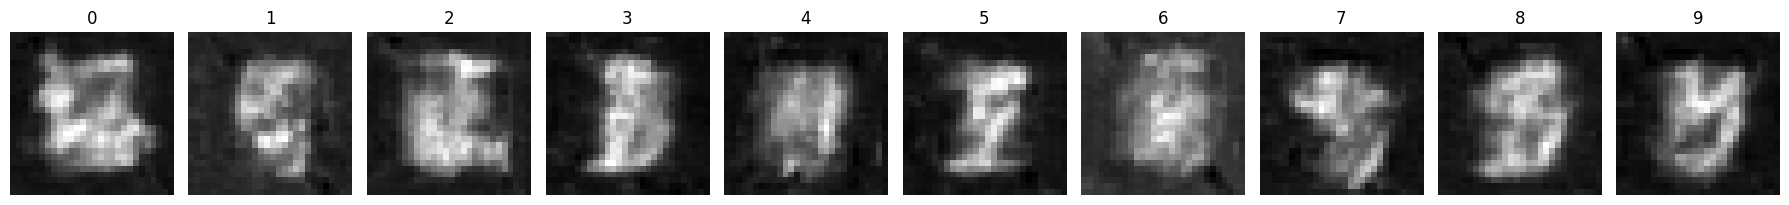

In [52]:
pure_noise = torch.randn(10, 1, 28, 28)*0.5
labels = torch.arange(10)
one_hot_labels = F.one_hot(labels, num_classes=10).float()

out = model(pure_noise, one_hot_labels).detach().numpy()

fig, ax = plt.subplots(1, 10, figsize=(18, 3))
for i in range(10):
    ax[i].imshow(out[i].squeeze(), cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(str(labels[i].item()))

plt.tight_layout()
plt.show()

I mean...it's not great, but it's better than using the pure U-Net. We are actually asking an *awful* lot from this model - we are asking it to generate images from noise in essentially a single step! That's a big ask. We should probably try and denoise an image iteratively...

## Things to try
1. In this notebook, added different amounts of noise during training. What if you only train on a large amount of noise?
2. Try changing the size of the network - add more layers, or more filters per layer. If you have access to one, try using a GPU.